## Import

In [60]:
import numpy as np
import pandas as pd

import os
import sys

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
# %matplotlib inline

import pickle
import cv2

import importlib
# from classifiers import R_from_path
%config InlineBackend.figure_format = 'png' 

In [2]:
current_dir = os.getcwd()
code_path = os.path.abspath(os.path.join(current_dir, '..', '..', 'codes'))
data_path = os.path.abspath(os.path.join(current_dir, '..', '..', 'data'))

sys.path.append(os.path.join(code_path, 'project_x_ray_images_stack'))
# sys.path.append(r'E:\photoelectric_sorting\codes\project_x_ray_images_stack')

In [3]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [4]:
from scipy.optimize import curve_fit
from sklearn.metrics import accuracy_score

In [5]:
from matplotlib import rc

rc('text', usetex=False)
font = {'family': 'serif',
        'serif': 'Times New Roman',
        'weight': 'normal',
        'size': 10}
rc('font', **font)

In [6]:
import seaborn as sns

# sns.set_context("notebook")
# sns.set_context('talk')
# sns.set_style("ticks")
# sns.set_style("whitegrid")

sns.reset_defaults()


In [7]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [8]:
import dataloader
importlib.reload(dataloader)
from dataloader import path2truth, path2pixel, load_data

In [9]:
path_0219 = os.path.join(data_path, '20250219/160kV_4mA_forward.png')
excel_0219 = os.path.join(data_path, '化验结果/20250219化验结果.xlsx')

excel_0224 = os.path.join(data_path, '化验结果/20250224化验结果.xlsx')
path_0224 = os.path.join(data_path, '20250224/160kV_4mA_forward.png')

#low_0219, high_0219, rock_pixels_19, low_contoured_19, contours 
# pre_0219_2 = path2pixel(path_0219, [105, 1000, 400, 1200], max_len = 6, length=102, th_val = 105,
#                                   direction = 'ublr', s_i = 64, save_rock_image=False)

# pre_0219_1 = path2pixel(path_0219, [1950, 2844, 350, 1150], max_len = 9, length=35, th_val = 105,
#                                   direction = 'ublr', s_i = 1, save_rock_image=False)

# pre_0219 =[append_generic(pre_0219_1[i], pre_0219_2[i]) for i in range(len(pre_0219_1))]

# pixel_data = {
#     '0219': {
#         'low': pre_0219[2][0],
#         'high': pre_0219[2][1]
#     },
# }
# with open('0219_pixels.pkl', 'wb') as f:
#     pickle.dump(pixel_data, f)

#low_0219, high_0219, rock_pixels_19, low_contoured_19, contours 
z = path2pixel(path_0219, [[105, 1000, 400, 1200], [1950, 2844, 350, 1150]], max_len = [6, 9], length = [102, 35], 
           s_i = [64, 1], th_val = 105, save_rock_image = False, direction = 'ublr', save_rock_pixels=False)

consts = [5, 20]; th_val = 110

y = path2pixel(path_0224, [[105, 1000, 400, 1200], [1850,-100, 350,1150]], max_len = [6, 9], length=[102, 35], 
               s_i = [64, 1], th_val = 110, save_rock_image = False, direction = 'ublr', save_rock_pixels=False)


2025-04-03 08:25:20,181 - INFO - 2个盒子的图像转换rock_pixels完成。
2025-04-03 08:25:20,427 - INFO - 2个盒子的图像转换rock_pixels完成。


In [10]:
input_0224 = load_data(y[2], excel_0224)
input_0219 = load_data(z[2], excel_0219)

2025-04-03 08:25:21,272 - INFO - 加载数据完成。清洗后的样本数量: 102
2025-04-03 08:25:21,291 - INFO - 加载数据完成。清洗后的样本数量: 98


In [134]:
input_both = [[],]
# pixels
input_both[0].append(input_0224[0][0].copy(deep = True))
input_both[0][0].index += 99

input_both[0].append(input_0224[0][1].copy(deep = True))
input_both[0][1].index += 99
# truth
input_0219[1]['source'] = '0219'
input_0224[1]['source'] = '0224'
input_both.append(input_0224[1].copy(deep = True))
input_both[1].index += 99

input_both[0][0] = pd.concat([input_0219[0][0], input_both[0][0]], axis = 0)
input_both[0][1] = pd.concat([input_0219[0][1], input_both[0][1]], axis = 0)

input_both[1]= pd.concat([input_0219[1], input_both[1]], axis = 0)

input_both[1]['Zn_Pb_grade'] = input_both[1]['Zn_grade'] + input_both[1]['Pb_grade']

In [135]:
input_both[1]

,Sample No.,Fe_grade,Zn_grade,Pb_grade,S_grade,weight,source,Zn_Pb_grade
0,1,30.130,0.031,0.063,34.83,39.9,0219,0.094
1,2,7.446,0.784,2.125,6.72,50.4,0219,2.909
2,3,30.480,0.058,0.045,31.65,69.8,0219,0.103
3,4,31.200,0.089,0.319,31.76,48.8,0219,0.408
4,5,9.662,10.170,1.353,11.81,48.7,0219,11.523
...,...,...,...,...,...,...,...,...
199,101,7.973,1.509,1.325,0.00,38.8,0224,2.834
200,102,10.970,0.062,0.046,0.00,27.9,0224,0.108
201,103,25.000,0.086,0.118,0.00,32.7,0224,0.204
202,104,6.502,0.177,0.076,0.00,68.7,0224,0.253


## definitions

In [17]:
def calculate_rates(predictions, true_results, count_Fe = False):
    '''
    计算抛废率、回收率、铅锌富集比、铅锌平均品位
    :param predictions: 预测结果，一维数组
    :param true_results: 真实结果，excel表格
    
    :return: 抛废率、回收率、铅锌富集比、铅锌平均品位
    '''
    high_grade_mask = predictions == 1
    low_grade_mask = predictions == 0

    Fe_grade = true_results[:, 1]
    zn_grade = true_results[:, 2]
    pb_grade = true_results[:, 3]
    zn_pb_grade = zn_grade + pb_grade

    if count_Fe:
        zn_pb_grade = zn_grade + pb_grade + Fe_grade

    weight = true_results[:, 5]

    miss = (zn_grade == 0).sum()
    correction = len(predictions)/(len(predictions) - miss)

    # 计算抛废率和回收率
    scrap_rate = weight[low_grade_mask].sum() / weight.sum()
    recovery_rate = (weight[high_grade_mask] * zn_pb_grade[high_grade_mask]).sum() / (weight * zn_pb_grade).sum()

    # 计算富集率
    avg_pb_grade_all = pb_grade.mean()*correction
    avg_zn_grade_all = zn_grade.mean()*correction

    avg_pb_grade_high = (pb_grade[high_grade_mask] * weight[high_grade_mask]).sum()/weight[high_grade_mask].sum()
    avg_zn_grade_high = (zn_grade[high_grade_mask] * weight[high_grade_mask]).sum()/weight[high_grade_mask].sum()
    avg_pb_grade_low = (pb_grade[low_grade_mask] * weight[low_grade_mask]).sum()/weight[low_grade_mask].sum()
    avg_zn_grade_low = (zn_grade[low_grade_mask] * weight[low_grade_mask]).sum()/weight[low_grade_mask].sum()

    # avg_pb_grade_high = pb_grade[high_grade_mask].mean()*correction
    # avg_zn_grade_high = zn_grade[high_grade_mask].mean()*correction
    # avg_pb_grade_low =  pb_grade[low_grade_mask].mean()*correction
    # avg_zn_grade_low = zn_grade[low_grade_mask].mean()*correction

    enrichment_Pb = avg_pb_grade_high / avg_pb_grade_all if avg_pb_grade_all != 0 else 0
    enrichment_Zn = avg_zn_grade_high / avg_zn_grade_all if avg_zn_grade_all != 0 else 0

    return {
        '抛废率': '%.3f'%scrap_rate,
        '回收率': '%.3f'%recovery_rate,
        '铅富集比': '%.3f'%enrichment_Pb,
        '锌富集比': '%.3f'%enrichment_Zn,
        '铅平均品位（保留）': '%.3f'%avg_pb_grade_high,
        '锌平均品位（保留）': '%.3f'%avg_zn_grade_high,
        '铅平均品位（抛废）': '%.3f'%avg_pb_grade_low,
        '锌平均品位（抛废）': '%.3f'%avg_zn_grade_low,
        '铅平均品位': '%.3f'%avg_pb_grade_all,
        '锌平均品位': '%.3f'%avg_zn_grade_all,
    }

def get_and_plot_rates(R_mean, rrange, true, condition, count_Fe = False, accuracy_weight = None, title = '', plot = False):
    '''
    计算并画出抛废率和回收率随R阈值变化的曲线
    :param R_mean: R值的均值
    :param range: R阈值的范围
    :param true: 真实的化验数据
    :param condition: 认为是精矿的条件
    '''

    final = [[], [], [], []]

    for r in rrange:
        pre = R_mean >  r
        res = calculate_rates(pre, true, count_Fe=count_Fe)
        score = accuracy_score(condition, pre, sample_weight=accuracy_weight)
        # print('%.3f'%r, '%.3f'%score, res)

        final[0].append(r)
        final[1].append(score)
        final[2].append(float(res['抛废率']))
        final[3].append(float(res['回收率']))

    if plot:

        # plt.axhline(y=95, color='k', linestyle='--', alpha = 0.5, label = '95%')

        # plt.axvline(x=0.72, color='k', linestyle='--', alpha = 0.5, label = '$R_{thresh} = 0.72$')
        # plt.axvline(x=0.70, color='k', linestyle='--', alpha = 0.5, label = '$R_{thresh} = 0.70$')

        # plt.text(x = 0.73, y = 92, s = 'R = 0.72, scrap%=35%, \n recovery%=94%', fontsize = 15)
        plt.plot(final[0], final[1], label = 'classification score')
        plt.plot(final[0], final[2], label = 'scrap rate')
        plt.plot(final[0], final[3], label = 'recovery rate')
        
        plt.legend(fontsize = 15, frameon = False)
        plt.xlabel('R threshold')
        plt.ylabel('Rates (%)')
        plt.title(title)
        plt.show()

    return final

## analysis

In [ ]:
# I0_low, I0_high = 195, 196
# path_0219 = "E:/photoelectric_sorting/data/20250219/160kV_4mA_forward.png"
# path_0217 = "E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/160kV_4mA.png" #[110, 1000, 400, 1200]

# path_0219 = os.path.join(data_path, '20250219/160kV_4mA_forward.png')

# #low_0219, high_0219, rock_pixels_19, low_contoured_19, contours 
# pre_0219_2 = prepare_R(path_0219, [105, 1000, 400, 1200], max_len = 6, length=102, th_val = 105,
#                                   direction = 'ublr', s_i = 64, save_rock_image=False)

# pre_0219_1 = prepare_R(path_0219, [1950, -100, 350, 1150], max_len = 9, length=35, th_val = 105,
#                                   direction = 'ublr', s_i = 1, save_rock_image=False)

# pre_0219 =[append_generic(pre_0219_1[i], pre_0219_2[i]) for i in range(len(pre_0219_1))]

# #R_0219_pixels, R_0219_image
# consts = [5, 20]
# results_0219 = R_from_path(*pre_0219[0:3], I0_low, I0_high, input = 'pixels', method = 'a', const=consts)   
# R_0219_mean = np.array([results_0219[0][i].mean() for i in range(len(results_0219[0]))])

/var/folders/dm/mjb3j0rx4mg43ppsjkbnm1jr0000gn/T/ipykernel_17420/885882899.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


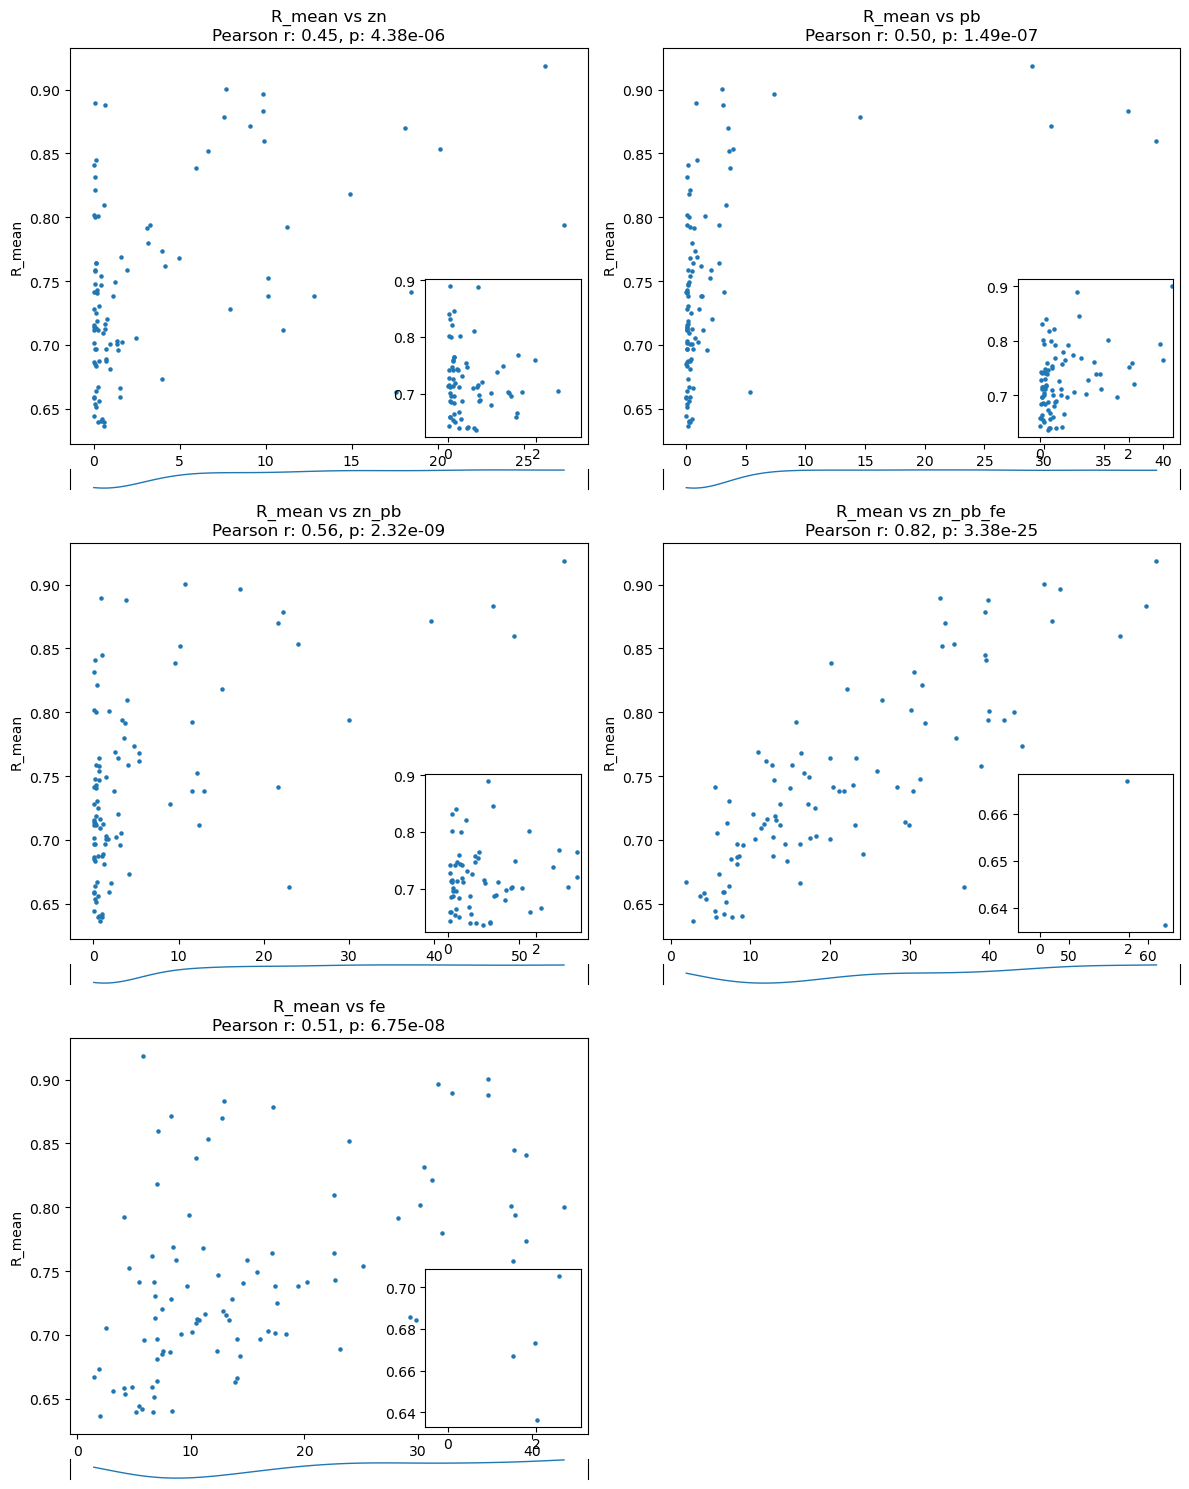

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable  # 新增导入
from scipy.stats import gaussian_kde

# 创建一个包含 2x2 子图的 Figure
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for data in [input_0219]:  # , input_0224, input_both]:
    fig, axes = plt.subplots(3, 2, figsize=(12, 15))
    zn = data[1]['Zn_grade']
    pb = data[1]['Pb_grade']
    fe = data[1]['Fe_grade']
    zn_pb = zn + pb
    zn_pb_fe = zn + pb + data[1]['Fe_grade']
    R_0219 = RMethodClassifier(pixels=data[0], truth=data[1], I0_low=195, I0_high=196, input='pixels', method='a', const=[5, 20])
    R_mean = R_0219.R_pixels.apply(np.mean)
    data_pairs = [(zn, R_mean), (pb, R_mean), (zn_pb, R_mean), (zn_pb_fe, R_mean), (fe, R_mean)]
    labels = ['zn', 'pb', 'zn_pb', 'zn_pb_fe', 'fe']
    marker_size = 5
    
    for i, (ax, (x, y), label) in enumerate(zip(axes.flat, data_pairs, labels)):
        # 绘制主散点图
        ax.scatter(x, y, s=marker_size)
        corr, p = pearsonr(x, y)
        ax.set_title(f'R_mean vs {label}\nPearson r: {corr:.2f}, p: {p:.2e}')
        ax.set_xlabel(label)
        ax.set_ylabel('R_mean')

        # 创建嵌入的小图
        axins = inset_axes(ax, width="30%", height="40%", loc='lower right')
        mask = (x >= 0) & (x <= 3)
        x_zoom = x[mask]
        y_zoom = y[mask]
        axins.scatter(x_zoom, y_zoom, s=marker_size)
        axins.set_xlim(-0.5, 3)

        # 新增：创建密度分布图
        divider = make_axes_locatable(ax)
        ax_density = divider.append_axes("bottom", size=0.2, pad=0.25, sharex=ax)
        kde = gaussian_kde(x)
        x_vals = np.linspace(x.min(), x.max(), 100)
        density = kde(x_vals)
        
        # 绘制密度曲线并填充
        ax_density.plot(x_vals, density, color='#1f77b4', lw=1)
        # ax_density.fill_between(x_vals, density, color='#1f77b4', alpha=0.4)
        
        # 反转y轴并调整格式
        ax_density.invert_yaxis()
        ax_density.set_yticks([])
        ax_density.xaxis.set_visible(False)  # 隐藏x轴
        ax_density.spines['top'].set_visible(False)
        # ax_density.spines['right'].set_visible(False)
        ax_density.spines['bottom'].set_visible(False)

    axes[2, 1].axis('off')

    # 调整布局避免重叠
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
R dis vs zn dis?

In [24]:
R_0219.R_pixels

0     [0.6013860655336569, 0.6115731431628648, 0.612...
1     [0.5947395768284489, 0.6025953573292401, 0.610...
2     [0.6009493009027412, 0.6092156122814837, 0.624...
3     [0.6009538575837248, 0.603029464575499, 0.6029...
4     [0.6054164655250774, 0.6245848176338565, 0.631...
                            ...                        
94    [0.5892783090088173, 0.5880481130919839, 0.594...
95    [0.6230756662334885, 0.6272595212678455, 0.612...
96    [0.5954078607629238, 0.6000687190283241, 0.595...
97    [0.597295678104129, 0.6024307532707767, 0.5974...
98    [0.598610686321509, 0.5981516919737219, 0.6025...
Length: 98, dtype: object

In [25]:
R_0219.truth

,Sample No.,Fe_grade,Zn_grade,Pb_grade,S_grade,weight
0,1,30.130,0.031,0.063,34.83,39.9
1,2,7.446,0.784,2.125,6.72,50.4
2,3,30.480,0.058,0.045,31.65,69.8
3,4,31.200,0.089,0.319,31.76,48.8
4,5,9.662,10.170,1.353,11.81,48.7
...,...,...,...,...,...,...
94,95,17.210,7.610,14.610,21.36,78.8
95,96,8.224,7.918,1.075,9.27,41.2
96,97,6.810,18.470,3.170,13.60,21.8
97,98,12.790,18.120,3.522,19.12,94.6


In [65]:
calculate_rates(zn_pb_0219[0:99] > 3, true_0219[0:99, :])

{'抛废率': '0.630', '回收率': '0.924'}

In [30]:
calculate_rates(zn_pb_fe_0219[0:99] > 10.0, true_0219[0:99, :])

{'抛废率': '0.212', '回收率': '0.969'}

## R_double_threshold()

In [88]:
import importlib
from classifiers import base_classifier
from classifiers import dual_thresh
from classifiers import r_method
from classifiers import demo

importlib.reload(base_classifier)
importlib.reload(dual_thresh)
importlib.reload(r_method)
importlib.reload(demo)

from classifiers import base_classifier
from classifiers.dual_thresh import DualThreshClassifier
from classifiers.r_method import RMethodClassifier
from classifiers.demo import Demo

import utils
importlib.reload(utils)
from utils import plot_curves

In [ ]:
def main(input, plot = False, include_Fe = False, title = ''):

    R_0219 = RMethodClassifier(pixels=input[0], truth=input[1], I0_low=195, I0_high=196, input= 'pixels', method= 'a', const= [5, 20], include_Fe = include_Fe)
    R_0219.tuning(min_recovery_rate=0.95, min_scrap_rate=0.2, A_range=np.arange(0.5, 1.2, 0.01), step_B=0.05)
    res_R, log_R = Demo(R_0219).report_rates()

    dual_0219 = DualThreshClassifier(pixels=input[0][0], truth=input[1], pixel_kind= 'grayness', include_Fe = include_Fe)
    dual_0219.tuning(min_recovery_rate=0.95, min_scrap_rate=0.2, A_range=np.arange(0, 256, 5), step_B=0.05)
    res_dual, log_dual = Demo(dual_0219).report_rates()

    if plot == True:

        plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
        # 绘制曲线

        rates = [[res_R['ideal'], 'ideal', 'blue'], 
                [res_R['baseline'], 'R_mean', 'green'],
                [res_R['dual_thresh'], 'R_dual_thresh', 'red'],
                [res_dual['dual_thresh'], 'Dual_thresh','black']]
                #  [test_r[-2], test_r[-1], 'R_method_single_thresh', 'purple']]

        try:
            plot_curves(
                title = title, 
                rates = rates,
                scrap_rates_ideal= res_R['ideal'][0],
                grade_thresholds_ideal=res_R['ideal'][2],
                best_sum_point=res_R['best_sum_point'],
                best_enrichment_point=res_R['best_enrichment_point'],
                best_constraint_point=res_R['best_constraint_point'])
        except:
            logging.error('error in plotting')

    return (R_0219, res_R, log_R), (dual_0219, res_dual, log_dual)


In [ ]:
dual_0219 = DualThreshClassifier(pixels=input_0219[0][0], truth=input_0219[1], pixel_kind= 'grayness')
dual_0219.tuning(min_recovery_rate=0.95, min_scrap_rate=0.2, A_range=np.arange(0, 256, 5), step_B=0.05)

AttributeError: 'DualThreshClassifier' object has no attribute 'find_closest_point'

In [68]:
res_0219 = main(input_0219, plot = False, include_Fe=False, title = '0219, w/o Fe')
res_0224 = main(input_0224, plot = False, include_Fe=False, title = '0224, w/o Fe')

In [149]:
R19 = res_0219[0][0]
D19 = res_0219[1][0]

pre_r19 = R19.classify_ores(*(R19.best_params))
pre_d19 = D19.classify_ores(*(D19.best_params))

In [160]:
accuracy_score(pre_r19, pre_d19)

0.9183673469387755

In [191]:
false = input_0219[1][pre_r19 == 0]
true = input_0219[1][pre_r19 == 1]
true_neg = (true['Zn_grade'] +  true['Pb_grade']) < 3
false_pos = (false['Zn_grade'] +  false['Pb_grade']) > 3

In [197]:
accuracy_score(pre_r19, (input_0219[1]['Zn_grade'] + input_0219[1]['Pb_grade']) > 3, normalize = False)

69.0

In [193]:
len(true[true_neg])

26

In [183]:
false[false_pos] # 品位大于3却被R值法分类为低品位的样本

,Sample No.,Fe_grade,Zn_grade,Pb_grade,S_grade,weight,source
55,56,1.962,3.960,0.183,2.61,24.2,0219
59,60,5.850,1.428,1.741,1.47,38.3,0219
90,91,2.516,2.490,0.766,1.91,61.1,0219


<BarContainer object of 98 artists>

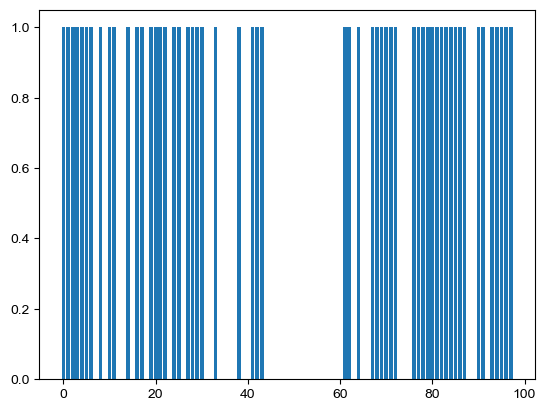

In [161]:
plt.bar(np.arange(len(pre_r19)), pre_r19)


<BarContainer object of 98 artists>

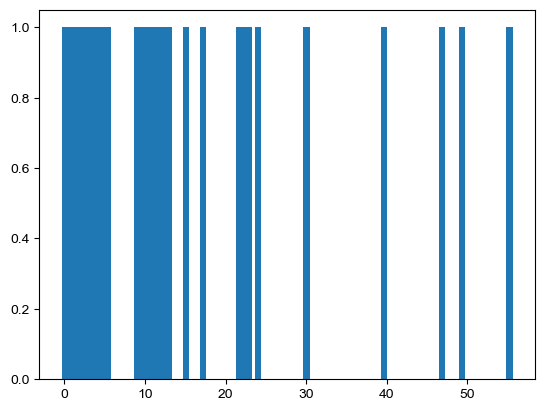

In [159]:
plt.bar(input_0219[1]['Pb_grade'] + input_0219[1]['Zn_grade'], pre_d19)

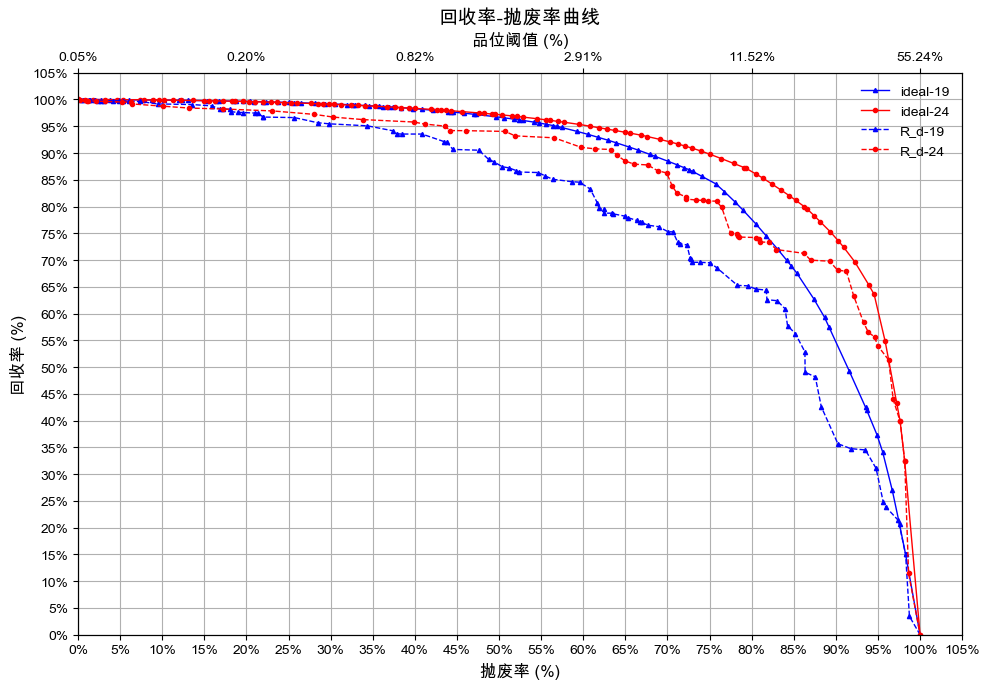

In [146]:
# rates = [[res_R['ideal'][0:2], 'ideal', 'blue'], 
#         [res_R['baseline'][0:2], 'R_mean', 'green'],
#         [res_R['dual_thresh'][0:2], 'R_dual_thresh', 'red'],
#         [res_dual['dual_thresh'][0:2], 'Dual_thresh','black']]

rates = [[res_0219[0][1]['ideal'][0:2], 'ideal-19', 'blue', '-', '^'], 
         [res_0224[0][1]['ideal'][0:2], 'ideal-24', 'red', '-', 'o'],
         [res_0219[0][1]['dual_thresh'][0:2], 'R_d-19', 'blue', '--', '^'],
         [res_0224[0][1]['dual_thresh'][0:2], 'R_d-24', 'red', '--', 'o']]
try:
    plot_curves(
        title = '回收率-抛废率曲线', 
        rates = rates,
        scrap_rates_ideal= res_0219[0][1]['ideal'][0],
        grade_thresholds_ideal=res_0219[0][1]['ideal'][2],
        best_constraint_point=res_0219[0][1]['best_constraint_point'])
except:
    logging.error('error in plotting')

In [29]:
R_mod = res_0219_fe[0][0]
D_mod = res_0219_fe[1][0]

In [58]:
# mask = [True]*98
np.average(input_both[1]['Fe_grade'], weights=input_both[1]['weight'])

13.45195578235766

In [91]:
input_0219[1]

,Sample No.,Fe_grade,Zn_grade,Pb_grade,S_grade,weight
0,1,30.130,0.031,0.063,34.83,39.9
1,2,7.446,0.784,2.125,6.72,50.4
2,3,30.480,0.058,0.045,31.65,69.8
3,4,31.200,0.089,0.319,31.76,48.8
4,5,9.662,10.170,1.353,11.81,48.7
...,...,...,...,...,...,...
94,95,17.210,7.610,14.610,21.36,78.8
95,96,8.224,7.918,1.075,9.27,41.2
96,97,6.810,18.470,3.170,13.60,21.8
97,98,12.790,18.120,3.522,19.12,94.6


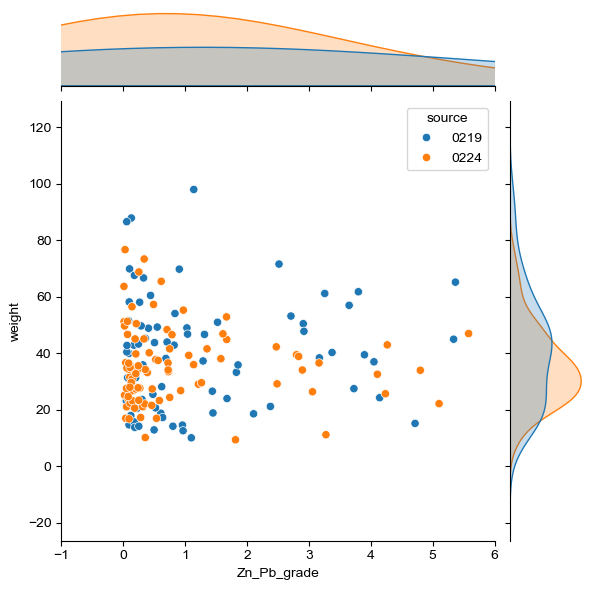

In [144]:

sns.jointplot(data=input_both[1], x="Zn_Pb_grade", xlim = [-1, 6],
              y="weight", hue="source")

(array([57., 14.,  5.,  5.,  0.,  5.,  3.,  0.,  3.,  1.,  1.,  1.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.200000e-02, 4.926800e-01, 9.733600e-01, 1.454040e+00,
        1.934720e+00, 2.415400e+00, 2.896080e+00, 3.376760e+00,
        3.857440e+00, 4.338120e+00, 4.818800e+00, 5.299480e+00,
        5.780160e+00, 6.260840e+00, 6.741520e+00, 7.222200e+00,
        7.702880e+00, 8.183560e+00, 8.664240e+00, 9.144920e+00,
        9.625600e+00, 1.010628e+01, 1.058696e+01, 1.106764e+01,
        1.154832e+01, 1.202900e+01, 1.250968e+01, 

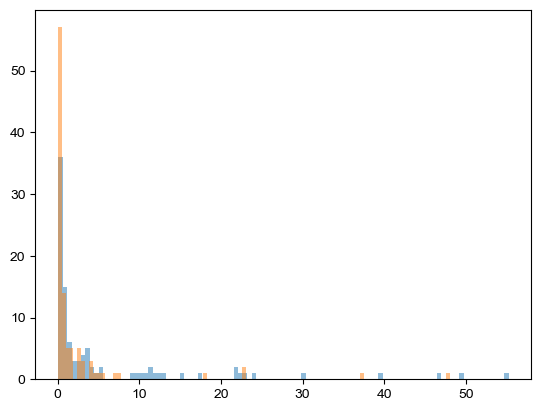

In [145]:
plt.hist(input_0219[1]['Zn_grade'] + input_0219[1]['Pb_grade'], bins=100, alpha=0.5, label='Zn+Pb')
plt.hist(input_0224[1]['Zn_grade'] + input_0224[1]['Pb_grade'], bins=100, alpha=0.5, label='Zn+Pb')

In [79]:
print(res_0219_fe[0][2])

未找到符合指定约束条件的合适参数。

=== AUC 结果 ===
AUC_基于化验品位: 0.6778
AUC_双阈值算法: 0.6561
AUC_平均值算法: 0.6528

=== 20%抛废率和95%回收率指标 ===
当回收率约为 92.56% 时，抛废率为 19.54%。此时的灰度阈值为0.8500000000000003，比例阈值为0.00%。
当回收率约为 95.11% 时，抛废率为 13.91%。此时的灰度阈值为0.7300000000000002，比例阈值为15.00%。



Text(0.5, 1.0, 'Accuracy and Grade')

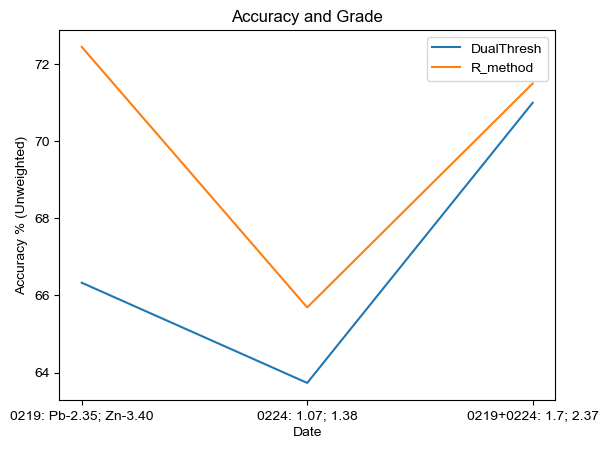

In [237]:
accuracy_dual = [66.33, 63.73, 71.00]
accuracy_R = [72.45, 65.69, 71.50]

plt.plot(accuracy_dual, label='DualThresh')
plt.plot(accuracy_R, label='R_method')
plt.xlabel('Date')
plt.ylabel('Accuracy % (Unweighted)')
plt.xticks(range(3), ['0219: Pb-2.35; Zn-3.40', '0224: 1.07; 1.38', '0219+0224: 1.7; 2.37'])
plt.legend()
plt.title('Accuracy and Grade')

In [226]:
with open('res_both_R.txt', 'w') as f:
    f.write(res_both[0][1])

with open('res_both_dual.txt', 'w') as f:
    f.write(res_both[1][1])

with open('res_0219_R.txt', 'w') as f:
    f.write(res_0219[0][1])

with open('res_0219_dual.txt', 'w') as f:
    f.write(res_0219[1][1])

with open('res_0224_R.txt', 'w') as f:
    f.write(res_0224[0][1])

with open('res_0224_dual.txt', 'w') as f:
    f.write(res_0224[1][1])

### 普通R值+阈值法

In [81]:
R_0219_mean.max()

0.9185747226139747

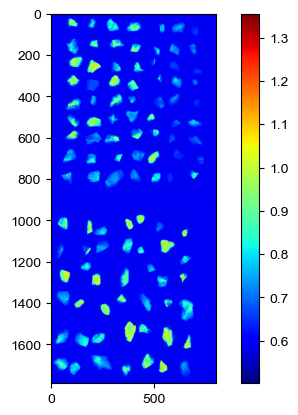

[[5, 0.198, 0.97], [6, 0.265, 0.951]]
0.7000000000000001 0.7100000000000001


{'抛废率': '0.265',
 '回收率': '0.951',
 '铅富集比': '1.449',
 '锌富集比': '1.406',
 '铅平均品位（保留）': '3.407',
 '锌平均品位（保留）': '4.782',
 '铅平均品位（抛废）': '0.352',
 '锌平均品位（抛废）': '0.830',
 '铅平均品位': '2.352',
 '锌平均品位': '3.401'}

In [82]:

consts = [5, 20]
results_0219 = R_from_path(*pre_0219[0:3], I0_low, I0_high, input = 'pixels', method = 'a', const=consts)
plt.imshow(results_0219[1], cmap = 'jet')   
plt.colorbar()
plt.show()
R_0219_mean = np.array([results_0219[0][i].mean() for i in range(len(results_0219[0]))])
minr = R_0219_mean.min(); maxr = R_0219_mean.max()
# rrange = np.arange(minr, maxr, 0.001)
rrange = np.arange(0.65, 0.9, 0.01)
test_r = get_and_plot_rates(R_0219_mean[:99], rrange, true_0219[0:99, :], 
                   zn_pb_0219[0:99] > 3, title = 'Zn + Pb > 3', accuracy_weight=weight[0:99], plot=False)

closest_points = find_closest_point(test_r[2], test_r[3], target = [0.20, 0.95])
print(closest_points)
print(rrange[closest_points[0][0]], rrange[closest_points[1][0]]) # 找出满足对应抛费率和回收率的R值
calculate_rates(R_0219_mean[0:99] > rrange[closest_points[1][0]], true_0219[0:99, :])


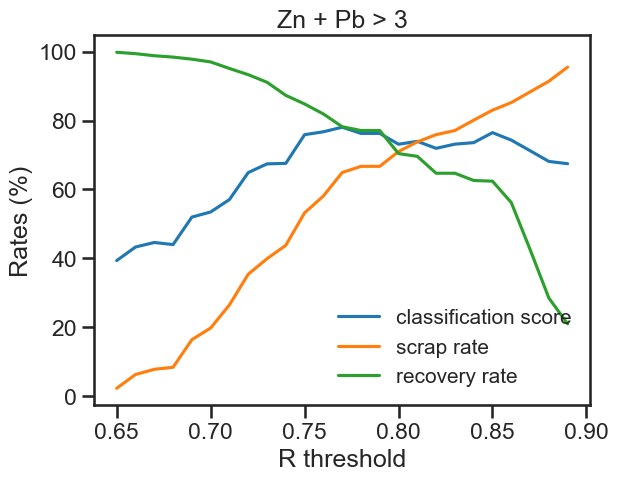

[[19.8, 97.0], [26.5, 95.1]]


In [ ]:
test_r = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9, 0.01], true_0219[0:99, :], 
                   zn_pb_0219[0:99] > 3, title = 'Zn + Pb > 3', accuracy_weight=weight[0:99], plot=False)
print(find_closest_point(test_r[2], test_r[3]))

In [148]:
final_0219_by_weight = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9], true_0219[0:99, :], 
                   zn_pb_0219[0:99] > 3, title = 'Zn + Pb > 3', accurace_weight=weight[0:99])

final_0219_no_weight = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9], true_0219[0:99, :], 
                   zn_pb_0219[0:99] > 3, title = 'Zn + Pb > 3', accurace_weight=None)

final_0219_by_zn_pb_grade = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9], true_0219[0:99, :], 
                   zn_pb_0219[0:99] > 3, title = 'Zn + Pb > 3', accurace_weight=zn_pb_0219[0:99])

final_0219_by_zn_pb_fe_grade = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9], true_0219[0:99, :], 
                   zn_pb_fe_0219[0:99]> 10, title = 'Zn + Pb + Fe> 10', accurace_weight=zn_pb_fe_0219[0:99], plot=False)

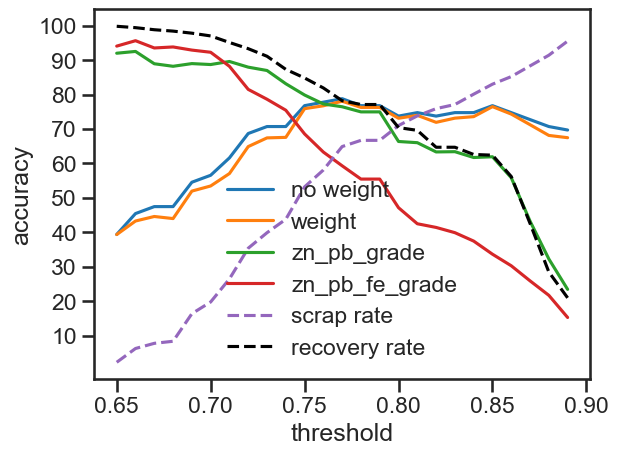

In [87]:
plt.plot(final_0219_no_weight[0], final_0219_no_weight[1], label = 'no weight')
plt.plot(final_0219_by_weight[0], final_0219_by_weight[1], label = 'weight')
plt.plot(final_0219_by_zn_pb_grade[0], final_0219_by_zn_pb_grade[1], label = 'zn_pb_grade')
plt.plot(final_0219_by_zn_pb_fe_grade[0], final_0219_by_zn_pb_fe_grade[1], label = 'zn_pb_fe_grade')

plt.plot(final_0219_no_weight[0],final_0219_no_weight[2], '--', label = 'scrap rate')
plt.plot(final_0219_no_weight[0],final_0219_no_weight[3], 'k--', label = 'recovery rate')

plt.yticks(np.arange(10, 101, 10))
plt.ylabel('accuracy')
plt.xlabel('threshold')
plt.legend(frameon = False)
plt.show()

In [24]:
results_dual_thresh = np.load('results_dual_thresh.npy')

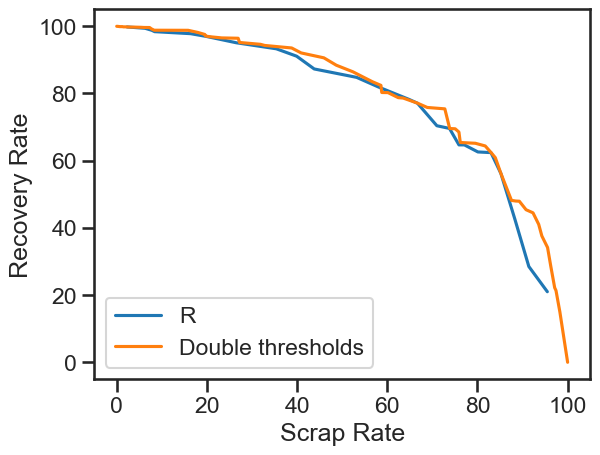

In [32]:

plt.plot(final_0219[2], final_0219[3], label = 'R')
plt.plot(results_dual_thresh[0]*100, results_dual_thresh[1]*100, label = 'Double thresholds')
plt.xlabel('Scrap Rate')
plt.ylabel('Recovery Rate')
plt.legend()
plt.show()

#### test on 0217 data

In [869]:
#R_0219_pixels, R_0219_image, low_0219, high_0219, low_contoured_19, rock_pixels_19, contour
results_0217 = R_from_path(path_0217, [None, None, None, None], I0_low, I0_high, 
                            input = 'pixels', method = 'a', max_len = 7, length=35,
                            direction = 'lrub', s_i = 0, save_rock_image=False)

In [874]:
R_0217_mean = np.array([results_0217[0][i].mean() for i in range(42)])
true_0217 = [1]*21 + [0]*21

In [929]:
for r in np.arange(0.7, 0.85, 0.01):
    print('%.2f'%r, '%.2f'%accuracy_score(true_0217, R_0217_mean > r, normalize=True))

0.70 0.86
0.71 0.88
0.72 0.93
0.73 0.95
0.74 0.95
0.75 1.00
0.76 1.00
0.77 0.95
0.78 0.90
0.79 0.90
0.80 0.88
0.81 0.88
0.82 0.88
0.83 0.83
0.84 0.81
0.85 0.79


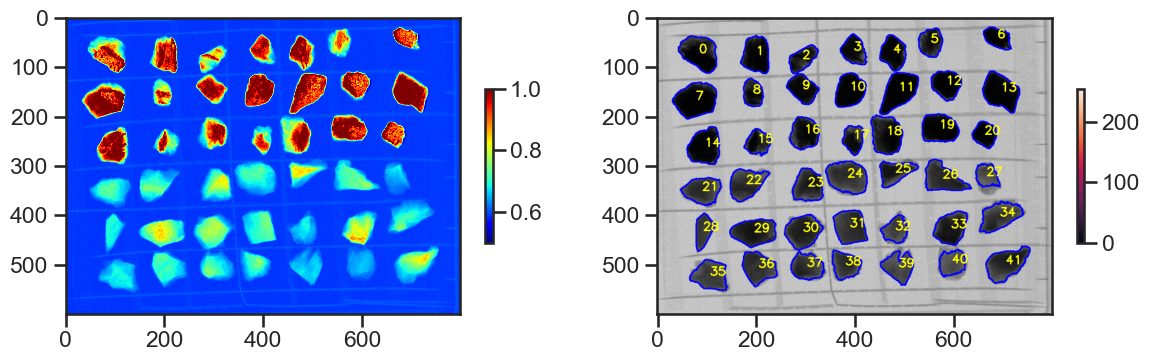

In [927]:
fig, axes = plt.subplots(1,2, figsize=(14,4))
im = axes[0].imshow(results_0217[1][50:650, 400:1200], vmin = 0.5, vmax = 1, cmap = 'jet')
fig.colorbar(im, ax=axes[0], shrink=0.5)
im6 = axes[1].imshow(results_0217[-3][50:650, 400:1200])
fig.colorbar(im6, ax = axes[1], shrink=0.5)

plt.show()

### fitting method

- I_high - I_low
- R - I_low

In [931]:
#R_0219_pixels, R_0219_image, low_0219, high_0219, low_contoured_19, rock_pixels_19, contours
len(results_0217[-2][1])

42

In [1023]:
I_low_g = [rock.mean() for rock in results_0217[-2][0][0:21]]
I_high_g = [rock.mean() for rock in results_0217[-2][1][0:21]]
R_g = R_0217_mean[0:21]
R_b = R_0217_mean[21:]
I_low_b = [rock.mean() for rock in results_0217[-2][0][21:]]
I_high_b = [rock.mean() for rock in results_0217[-2][1][21:]]

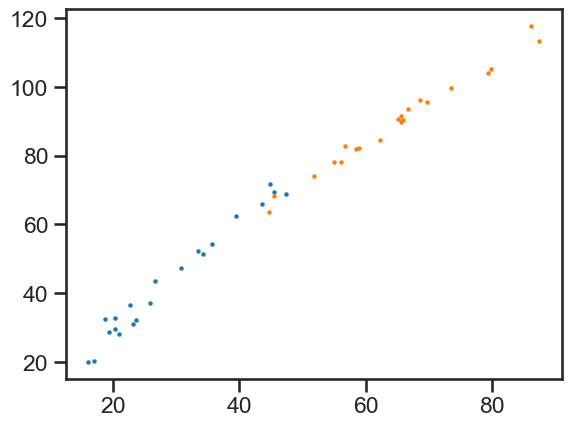

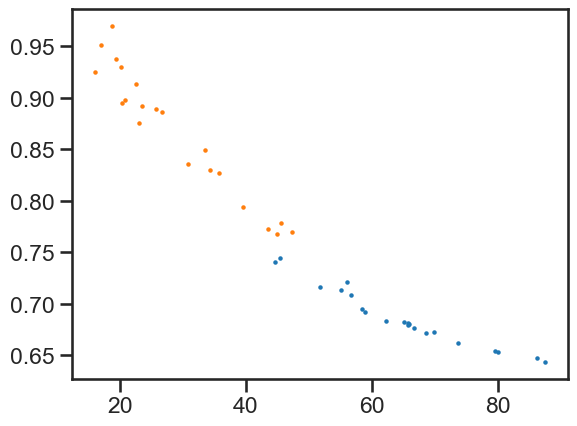

In [1024]:
plt.scatter(I_low_g, I_high_g, s=3)
plt.scatter(I_low_b, I_high_b, s=3)
plt.show()
plt.scatter(I_low_b, R_b, s=3)
plt.scatter(I_low_g, R_g, s=3)
plt.show()

In [1070]:
def plot_dis(low_mask, high_mask):
    I_low_g = [rock.mean() for rock, m in zip(results_0219[-1][0], high_mask) if m]
    I_high_g = [rock.mean() for rock, m in zip(results_0219[-1][1], high_mask) if m]

    R_g = R_0219_mean[0:99][high_mask]
    R_b = R_0219_mean[0:99][low_mask]
    I_low_b = [rock.mean() for rock, m in zip(results_0219[-1][0], low_mask) if m]
    I_high_b = [rock.mean() for rock, m in zip(results_0219[-1][1], low_mask) if m]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].scatter(I_low_g, I_high_g, s=3, label='ore')
    axes[0].scatter(I_low_b, I_high_b, s=3, label='waste')
    axes[0].set_xlabel('I_low')
    axes[0].set_ylabel('I_high')

    x1 = np.linspace(axes[0].get_xlim()[0], axes[0].get_xlim()[1], 100)
    axes[0].plot(x1, x1, color='red', linestyle='--', label='y = x', alpha = 0.6)

    axes[0].legend(frameon=False)

    axes[1].scatter(I_low_g, R_g, s=3, label='ore')
    axes[1].scatter(I_low_b, R_b, s=3, label='waste')
    axes[1].set_xlabel('I_low')
    axes[1].set_ylabel('R')
    axes[1].legend(frameon=False)

    plt.show()

    return {'I_low_g':I_low_g, 
            'I_high_g':I_high_g, 
            'R_g':R_g, 
            'I_low_b':I_low_b, 
            'I_high_b':I_high_b, 
            'R_b':R_b}

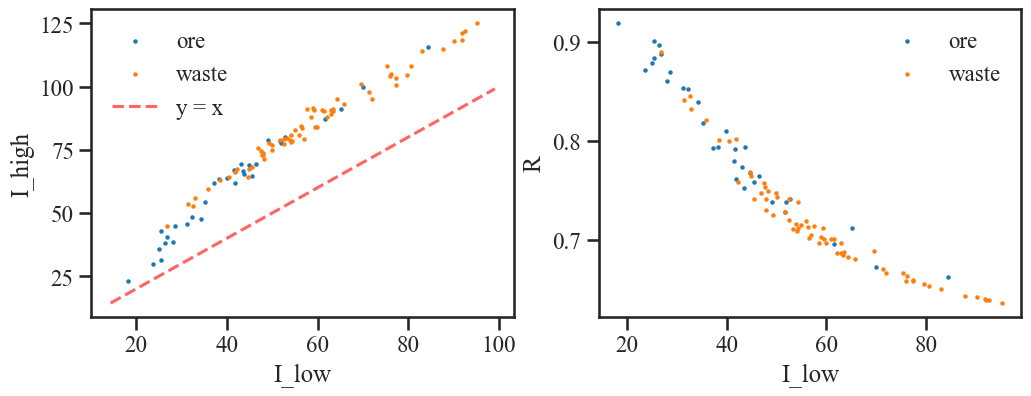

In [1061]:
high_mask = zn_pb_0219[0:99] > 3
plot_dis(~high_mask, high_mask)

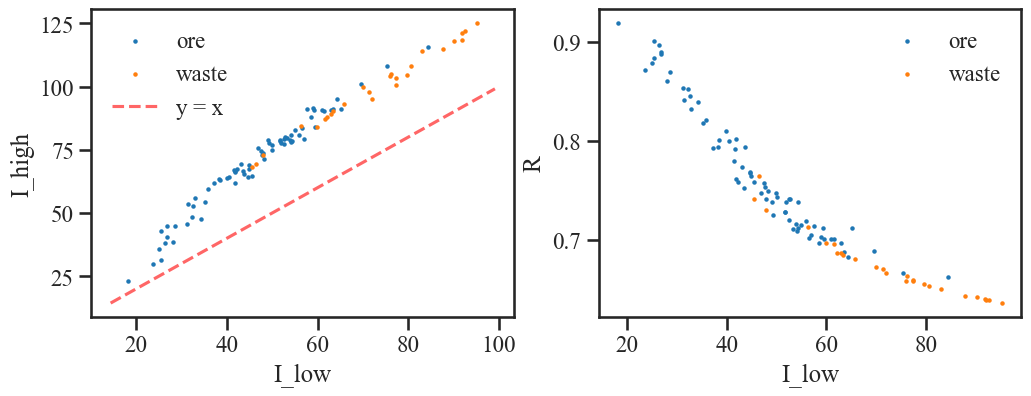

In [1071]:
high_mask = zn_pb_fe_0219[0:99] > 10
dis_fe = plot_dis(~high_mask, high_mask)

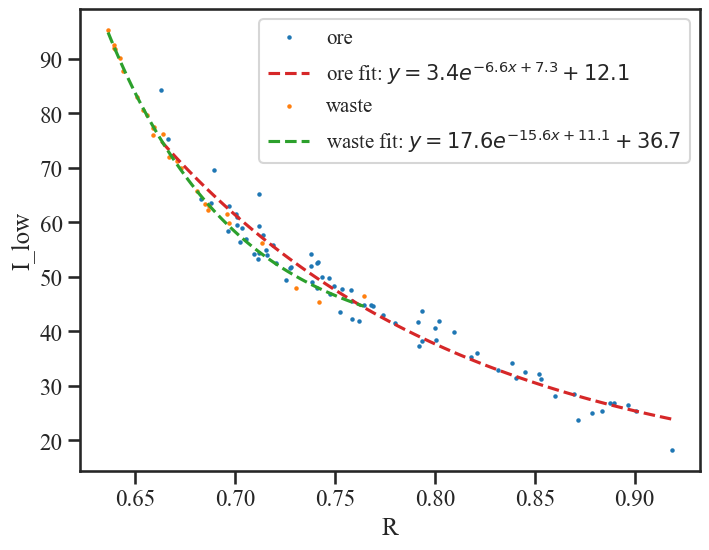

In [1150]:
def exponential_func(x, a, b, c, d):
    return a * np.exp(b * x + c) + d

I_low_g = dis_fe['I_low_g'] 
R_g = dis_fe['R_g']

I_low_b = dis_fe['I_low_b'] 
R_b = dis_fe['R_b']

# 对 ore 数据进行指数拟合
if len(I_low_g) > 0 and len(R_g) > 0:
    popt_ore, pcov  = curve_fit(exponential_func, R_g, I_low_g)
    x_ore = np.linspace(min(R_g), max(R_g), 100)
    y_ore = exponential_func(x_ore, *popt_ore)

# 对 waste 数据进行指数拟合
if len(I_low_b) > 0 and len(R_b) > 0:
    popt_waste, _ = curve_fit(exponential_func, R_b, I_low_b)
    x_waste = np.linspace(min(R_b), max(R_b), 100)
    y_waste = exponential_func(x_waste, *popt_waste)

plt.figure(figsize=(8, 6))
plt.scatter(R_g, I_low_g, s=3, label='ore')

formula_ore = f'$y = {popt_ore[0]:.1f}e^{{{popt_ore[1]:.1f}x + {popt_ore[2]:.1f}}} + {popt_ore[3]:.1f}$'

plt.plot(x_ore, y_ore, '--', color = cycle[3], label=f'ore fit: {formula_ore}')
plt.scatter(R_b, I_low_b, s=3, label='waste')
formula_waste = f'$y = {popt_waste[0]:.1f}e^{{{popt_waste[1]:.1f}x + {popt_waste[2]:.1f}}} + {popt_waste[3]:.1f}$'
plt.plot(x_waste, y_waste, '--', color = cycle[2], label=f'waste fit: {formula_waste}')
plt.legend(fontsize = 15)

plt.ylabel('I_low')
plt.xlabel('R')
plt.show()